In [35]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.0 MB/s eta 0:02:23
   ---------------------------------------- 1.0/150.0 MB 1.7 MB/s eta 0:01:26
    --------------------------------------- 2.1/150.0 MB 2.9 MB/s eta 0:00:52
    --------------------------------------- 2.1/150.0 MB 2.9 MB/s eta 0:00:52
    --------------------------------------- 2.6/150.0 MB 2.3 MB/s eta 0:01:04
    --------------------------------------- 3.1/150.0 MB 2.1 MB/s eta 0:01:10
   - -------------------------------------- 3.9/150.0 MB 2.4 MB/s eta 0:01:01
   - -------------------------------------- 5.0/150.0 MB 2.6 MB/s eta 0:00:56
   - -------------------------------------- 5.0/150.0 MB 2.6 MB/s eta 0:00:56
   - ---------

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [2]:
base_path="D:\\summer 2_nd\\Formula 1\\"
# df = pd.read_csv(f"{base_path}classifcation_dataset.csv", index_col= 0)
df = pd.read_csv(f"{base_path}binary_dataset.csv", index_col= 0)

In [10]:
corr = df.corr(numeric_only=True)
print(corr["is_podium"])


driverst_points                                0.494958
driverst_position                             -0.533889
driverst_wins                                  0.420941
css_points                                     0.458635
css_position                                  -0.513794
css_wins                                       0.405993
result_grid                                   -0.493671
q1                                            -0.015653
q2                                            -0.013938
q3                                            -0.019468
driver_circuit_avg_result_point_before_race   -0.274048
driver_circuit_avg_pitstops_before_race        0.069251
driver_avg_finish_pos_prior                   -0.494116
is_podium                                      1.000000
driver_podium_rate_prior                       0.503804
driver_avg_finish_last_3                      -0.510721
driver_experience_races                        0.168220
driver_experience_at_circuit                   0

In [3]:
pd.set_option("display.max_columns",0)
# df["result_position"].unique()
df["is_podium"].unique()

array([1, 0], dtype=int64)

In [26]:
df = pd.concat([df, df[df["driverRef"] == "doohan"]], ignore_index=True)
df = pd.concat([df, pd.concat([df[df["driverRef"] == "doohan"]]*2, ignore_index=True)], ignore_index=True)


In [159]:
# correlation_matrix = df[numeric_features +["is_podium"]].corr()
# plt.figure(figsize=(25,20))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
# plt.plot


In [5]:
train_val_df, test_df = train_test_split(
    df, 
    test_size=0.10, 
    random_state=42 ,
    # stratify=df["driverRef"]
    stratify=df["is_podium"]
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=2/9,
    random_state=42,
    stratify=train_val_df["is_podium"]
    # stratify=train_val_df["driverRef"]
)

<bound method Axes.plot of <Axes: title={'center': 'val'}, xlabel='driverRef'>>

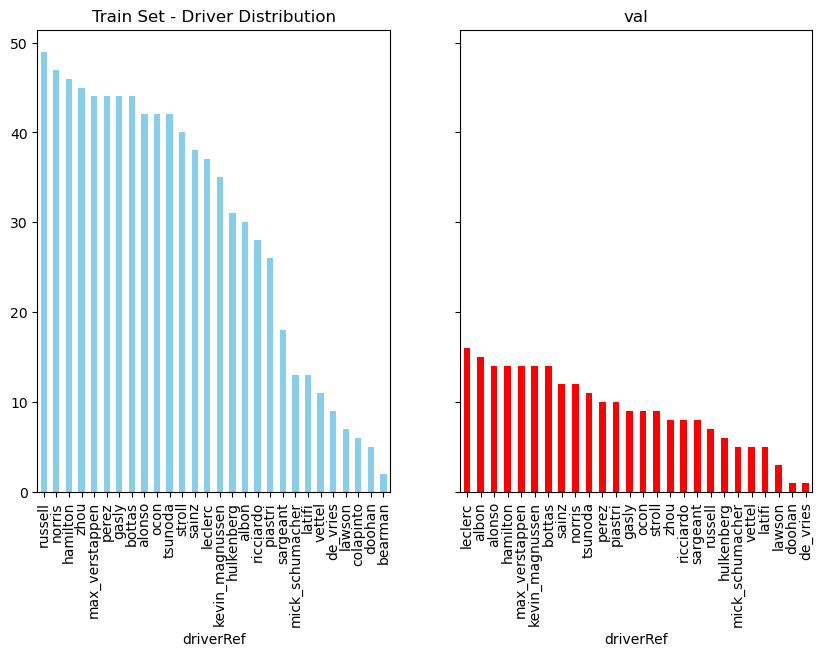

In [254]:
fig,axis = plt.subplots(nrows=1,ncols=2,figsize=(10,6),sharey=True)
train_df['driverRef'].value_counts().plot(kind='bar', ax=axis[0], color='skyblue')
axis[0].set_title('Train Set - Driver Distribution')
axis[0].plot

val_df['driverRef'].value_counts().plot(kind='bar', ax=axis[1], color='red')
axis[1].set_title("val")
axis[1].plot


In [29]:
# train_x = train_df.copy()
# train_x.drop(columns=["result_position"],inplace=True)
# train_label = train_df["result_position"]

# val_x = val_df.copy()
# val_x.drop(columns=["result_position"],inplace=True)
# val_label = val_df["result_position"]


# test_x = test_df.copy()
# test_x.drop(columns=["result_position"],inplace=True)
# test_label = test_df["result_position"]
#---------------------------------------------------------------
train_x = train_df.copy()
train_x.drop(columns=["is_podium"],inplace=True)
train_label = train_df["is_podium"]

val_x = val_df.copy()
val_x.drop(columns=["is_podium"],inplace=True)
val_label = val_df["is_podium"]


test_x = test_df.copy()
test_x.drop(columns=["is_podium"],inplace=True)
test_label = test_df["is_podium"]

In [256]:
categorical_cols = ['driverRef', 'constructorRef', 'race_name']
numeric_features = train_x.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_x.select_dtypes(include=['object', 'category']).columns.tolist()

In [257]:
scalar = StandardScaler()
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')

train_x_num = scalar.fit_transform(train_x[numeric_features])
val_x_num = scalar.transform(val_x[numeric_features])
test_x_num = scalar.transform(test_x[numeric_features])

train_x_cat = encoder.fit_transform(train_x[categorical_cols])
val_x_cat = encoder.transform(val_x[categorical_cols])
test_x_cat = encoder.transform(test_x[categorical_cols])

final_train_x = np.hstack([train_x_num,train_x_cat])
final_val_x = np.hstack([val_x_num,val_x_cat])
final_test_x = np.hstack([test_x_num,test_x_cat])


In [258]:
print(final_train_x.shape)
print(final_val_x.shape)
print(final_test_x.shape)


(838, 85)
(240, 85)
(120, 85)


In [259]:
train_label = train_label.ravel()  # or .values.ravel() if it's a Series
val_label = val_label.ravel()

C:\Users\ibrah\AppData\Local\Temp\ipykernel_8444\2011038880.py:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  train_label = train_label.ravel()  # or .values.ravel() if it's a Series
C:\Users\ibrah\AppData\Local\Temp\ipykernel_8444\2011038880.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  val_label = val_label.ravel()


In [260]:
final_val_x.shape

(240, 85)

In [261]:
# xgb_model = XGBClassifier(
#     objective='multi:softprob',  
#     num_class=20,                
#     n_estimators=300,             
#     max_depth=6,                  
#     learning_rate=0.05,          
#     subsample=0.8,                
#     colsample_bytree=0.7,        
#     use_label_encoder=False,
#     eval_metric='mlogloss'
# )

xgb_binary = XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_binary.fit(final_train_x, train_label,
               eval_set=[(final_val_x, val_label)],
               
               verbose=True)
val_preds = xgb_binary.predict(final_val_x)



[0]	validation_0-logloss:0.41091


[1]	validation_0-logloss:0.37969
[2]	validation_0-logloss:0.35456
[3]	validation_0-logloss:0.33341
[4]	validation_0-logloss:0.31632
[5]	validation_0-logloss:0.30451
[6]	validation_0-logloss:0.29342
[7]	validation_0-logloss:0.28111
[8]	validation_0-logloss:0.27214
[9]	validation_0-logloss:0.26498
[10]	validation_0-logloss:0.25631
[11]	validation_0-logloss:0.25022


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[12]	validation_0-logloss:0.24591
[13]	validation_0-logloss:0.24316
[14]	validation_0-logloss:0.23813
[15]	validation_0-logloss:0.23519
[16]	validation_0-logloss:0.23249
[17]	validation_0-logloss:0.23046
[18]	validation_0-logloss:0.22720
[19]	validation_0-logloss:0.22441
[20]	validation_0-logloss:0.22130
[21]	validation_0-logloss:0.22021
[22]	validation_0-logloss:0.21831
[23]	validation_0-logloss:0.21746
[24]	validation_0-logloss:0.21679
[25]	validation_0-logloss:0.21646
[26]	validation_0-logloss:0.21567
[27]	validation_0-logloss:0.21475
[28]	validation_0-logloss:0.21555
[29]	validation_0-logloss:0.21445
[30]	validation_0-logloss:0.21392
[31]	validation_0-logloss:0.21532
[32]	validation_0-logloss:0.21643
[33]	validation_0-logloss:0.21706
[34]	validation_0-logloss:0.21763
[35]	validation_0-logloss:0.21675
[36]	validation_0-logloss:0.21761
[37]	validation_0-logloss:0.21774
[38]	validation_0-logloss:0.21928
[39]	validation_0-logloss:0.21986
[40]	validation_0-logloss:0.21959
[41]	validatio

              precision    recall  f1-score   support

  Non-Podium       0.93      0.93      0.93       199
      Podium       0.68      0.68      0.68        41

    accuracy                           0.89       240
   macro avg       0.81      0.81      0.81       240
weighted avg       0.89      0.89      0.89       240

[[186  13]
 [ 13  28]]


<function matplotlib.pyplot.show(close=None, block=None)>

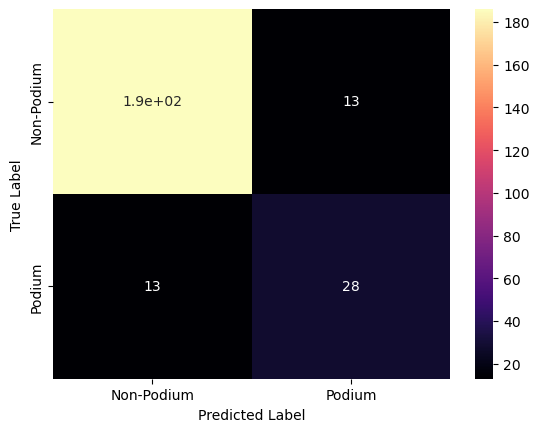

In [262]:

print(classification_report(val_label, val_preds, target_names=["Non-Podium", "Podium"]))
cm = confusion_matrix(val_label, val_preds)
print(cm)
sns.heatmap(cm, annot=True, cmap='magma', xticklabels=["Non-Podium", "Podium"], yticklabels=["Non-Podium", "Podium"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show

In [263]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8,10],
    'learning_rate': [0.01, 0.1, 0.2,0.4],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.5,0.7, 1.0]
}
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

grid_searcher = GridSearchCV(
    estimator= xgb,
    param_grid=param_grid,
    scoring="f1",
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_searcher.fit(final_train_x,train_label)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:08:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2, 0.4],
                         'max_depth': [4, 6, 8, 10], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='f1', verbose=2)

In [264]:
best_xgb_model = grid_searcher.best_estimator_
val_predicting_xgb_grid = best_xgb_model.predict(final_val_x)
print(classification_report(val_label, val_predicting_xgb_grid))
cm = confusion_matrix(val_label,val_predicting_xgb_grid)
print(cm)


              precision    recall  f1-score   support

           0       0.93      0.94      0.94       199
           1       0.69      0.66      0.68        41

    accuracy                           0.89       240
   macro avg       0.81      0.80      0.81       240
weighted avg       0.89      0.89      0.89       240

[[187  12]
 [ 14  27]]


In [272]:
random_forrest_without_grid= RandomForestClassifier(
    n_estimators=200,  
    max_depth=10,         
    random_state=42,
    n_jobs=-1,         
    class_weight='balanced' 
)
random_forrest_without_grid.fit(final_train_x,train_label)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [271]:
import joblib
joblib.dump(random_forrest_without_grid,f"{base_path}final.pkl")

['D:\\summer 2_nd\\Formula 1\\final.pkl']

              precision    recall  f1-score   support

  Non-Podium       0.96      0.92      0.94       199
      Podium       0.68      0.83      0.75        41

    accuracy                           0.90       240
   macro avg       0.82      0.87      0.84       240
weighted avg       0.91      0.90      0.91       240

[[183  16]
 [  7  34]]


<function matplotlib.pyplot.show(close=None, block=None)>

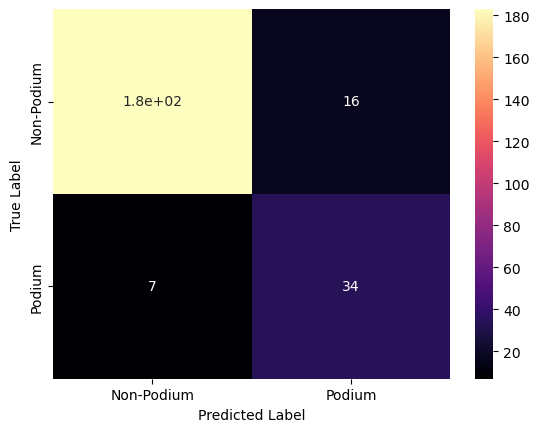

In [273]:
val_predictingl = random_forrest_without_grid.predict(final_val_x)
print(classification_report(val_label, val_predictingl, target_names=["Non-Podium", "Podium"]))
cm = confusion_matrix(val_label, val_predictingl)
print(cm)
sns.heatmap(cm, annot=True, cmap='magma', xticklabels=["Non-Podium", "Podium"], yticklabels=["Non-Podium", "Podium"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show

In [267]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=5, random_state=42)
scores = cross_val_score(random_forrest_without_grid, final_train_x, train_label, cv=cv, scoring='f1')
print("Avg F1:", scores.mean(), "Std Dev:", scores.std()) 


Avg F1: 0.622610931466186 Std Dev: 0.060380883366385786


In [268]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',     # or 'accuracy', 'roc_auc' depending on goal
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_search_rf.fit(final_train_x,train_label)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=2)

In [269]:
best_rf = grid_search_rf.best_estimator_
val_preds_rfg = best_rf.predict(final_val_x)
print(classification_report(val_label, val_preds, target_names=["Non-Podium", "Podium"]))
cm_fr_g = confusion_matrix(val_label,val_preds_rfg)
print(cm_fr_g)

              precision    recall  f1-score   support

  Non-Podium       0.93      0.93      0.93       199
      Podium       0.68      0.68      0.68        41

    accuracy                           0.89       240
   macro avg       0.81      0.81      0.81       240
weighted avg       0.89      0.89      0.89       240

[[175  24]
 [  4  37]]


In [249]:
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=5, random_state=42)
scores = cross_val_score(best_rf, final_train_x, train_label, cv=cv, scoring='f1')
print("Avg F1:", scores.mean(), "Std Dev:", scores.std()) 


Avg F1: 0.6667688057315116 Std Dev: 0.06876342509889945


In [ ]:
import joblib
joblib.dump(best_rf,f"{base_path}final.pkl")

['D:\\summer 2_nd\\Formula 1\\bestmodel_2nd_binary_f1.pkl']

In [ ]:
joblib.dump(random_forrest_without_grid,f"{base_path}model.pkl")

['D:\\summer 2_nd\\Formula 1\\model.pkl']

In [274]:
hello=random_forrest_without_grid.predict(final_test_x)
print(classification_report(test_label, hello, target_names=["Non-Podium", "Podium"]))
cm_fr_g = confusion_matrix(test_label,hello)

              precision    recall  f1-score   support

  Non-Podium       0.97      0.93      0.95       100
      Podium       0.71      0.85      0.77        20

    accuracy                           0.92       120
   macro avg       0.84      0.89      0.86       120
weighted avg       0.93      0.92      0.92       120



In [277]:
final_model = joblib.load(f"{base_path}model.pkl")

In [278]:
hello=final_model.predict(final_test_x)
print(classification_report(test_label, hello, target_names=["Non-Podium", "Podium"]))
cm_fr_g = confusion_matrix(test_label,hello)

              precision    recall  f1-score   support

  Non-Podium       0.97      0.93      0.95       100
      Podium       0.71      0.85      0.77        20

    accuracy                           0.92       120
   macro avg       0.84      0.89      0.86       120
weighted avg       0.93      0.92      0.92       120



In [33]:

categorical_cols = ['driverRef', 'constructorRef', 'race_name']
numeric_cols = train_x.select_dtypes(include=['int64', 'float64']).columns.tolist()


numeric_cols = [col for col in numeric_cols if col not in categorical_cols]


numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
   
])

pipeline.fit(train_x)



joblib.dump(pipeline, f'{base_path}f1_preprocessing_pipeline.pkl')


['D:\\summer 2_nd\\Formula 1\\f1_preprocessing_pipeline.pkl']